## Importing initial modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Importing data

### Initializing dataframe

In [2]:
df = pd.read_csv('../../datasets/data.csv')
df

,filename,r_mean,g_mean,b_mean,r_std,g_std,b_std,h_mean,v_mean,h_std,v_std,quality
0,imagens/selecionadas/boa_qualidade/3391453209.jpg,132.609966,121.227249,124.231548,77.783824,69.308145,67.421205,13.189166,13.277505,20.334358,21.528245,1
1,imagens/selecionadas/boa_qualidade/3274691778.jpg,66.165817,44.555141,16.569908,69.099801,57.499889,38.438030,5.298978,7.668856,10.649066,16.816179,1
2,imagens/selecionadas/boa_qualidade/3363342011.jpg,77.994858,70.928452,81.287174,95.512351,83.056987,65.150531,4.711894,7.193683,8.418819,13.501021,1
3,imagens/selecionadas/boa_qualidade/3359563671.jpg,75.615658,79.028858,88.636810,38.806435,37.705454,40.135014,3.963080,5.991780,9.907831,13.684910,1
4,imagens/selecionadas/boa_qualidade/3307667255.jpg,112.128551,98.476761,86.907909,67.015909,65.093914,64.762853,8.664269,14.697718,14.127406,23.532887,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2095,imagens/selecionadas/escuras_ruins/2015_03985.jpg,25.093895,24.500557,22.681580,24.635103,23.453142,22.314595,1.650287,1.694096,5.943454,8.405698,0
2096,imagens/selecionadas/escuras_ruins/2015_05839.jpg,16.278244,16.098171,16.927536,26.044997,25.645297,23.383744,0.821251,0.943275,3.102364,3.638713,0
2097,imagens/selecionadas/escuras_ruins/2015_00176.jpg,40.049698,12.688789,3.469101,37.774832,21.465189,8.702481,3.820762,3.532297,7.436229,7.322762,0
2098,imagens/selecionadas/escuras_ruins/2015_03045.png,29.009560,26.468601,24.881416,42.588287,41.339594,40.756837,1.746537,3.285583,5.360037,10.139739,0


### Extracting values

In [3]:
data = (df.values)[:, 1:]

### Splitting into attributes and targets

In [4]:
attributes = data[:, :-1]
targets = data[:, -1]

## Training model

### Setting parameter grid for Grid Search CV

In [5]:
parameters = {
    'svc__C' : [10**i for i in range(0, 3)],
    'svc__kernel' : ['rbf', 'poly'],
    'svc__gamma' : [10**i for i in range(-2, 0)],
    'svc__degree' : range(1, 4)
}

### Training and collecting scores

In [6]:
from sklearn.svm import SVC
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve
from tqdm import tqdm

folder = KFold(n_splits = 10, random_state=0, shuffle=True)

metrics = np.zeros((10, 6))

models = [
    [-1.0, None, None, None],
    [2.0, None, None, None]
]

for i, (train_index, test_index) in tqdm(enumerate(folder.split(attributes))):
    train_attributes, test_attributes, train_targets, test_targets = (
        attributes[train_index],
        attributes[test_index],
        targets[train_index],
        targets[test_index]
    )
    
    train_targets = train_targets.astype(float)
    test_targets = test_targets.astype(float)
    
    model = Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC(probability=True, random_state=0))])
    cv = GridSearchCV(estimator=model, param_grid=parameters, cv=5, n_jobs=-1)
    
    cv.fit(train_attributes, train_targets)
    
    model = cv.best_estimator_
    model.fit(train_attributes, train_targets)
    
    prediction = model.predict(test_attributes)
    prediction_proba = model.predict_proba(test_attributes)
    
    acc = accuracy_score(test_targets, prediction)
    cm = confusion_matrix(test_targets, prediction, normalize='true')
    prec = precision_score(test_targets, prediction)
    rec = recall_score(test_targets, prediction)
    f1 = f1_score(test_targets, prediction)
    
    metrics[i] = np.array([acc, cm[0][0], cm[1][1], prec, rec, f1]).astype(float)

    if acc > models[0][0]:
        models[0][0] = acc
        models[0][1] = roc_curve(test_targets, prediction_proba[:, 1])
        models[0][2] = model
        models[0][3] = cm
    elif acc < models[1][0]:
        models[1][0] = acc
        models[1][1] = roc_curve(test_targets, prediction_proba[:, 1])
        models[1][2] = model
        models[1][3] = cm

10it [08:44, 52.46s/it]


## Plotting Results

### Plotting metrics through partitions, means and standard deviations

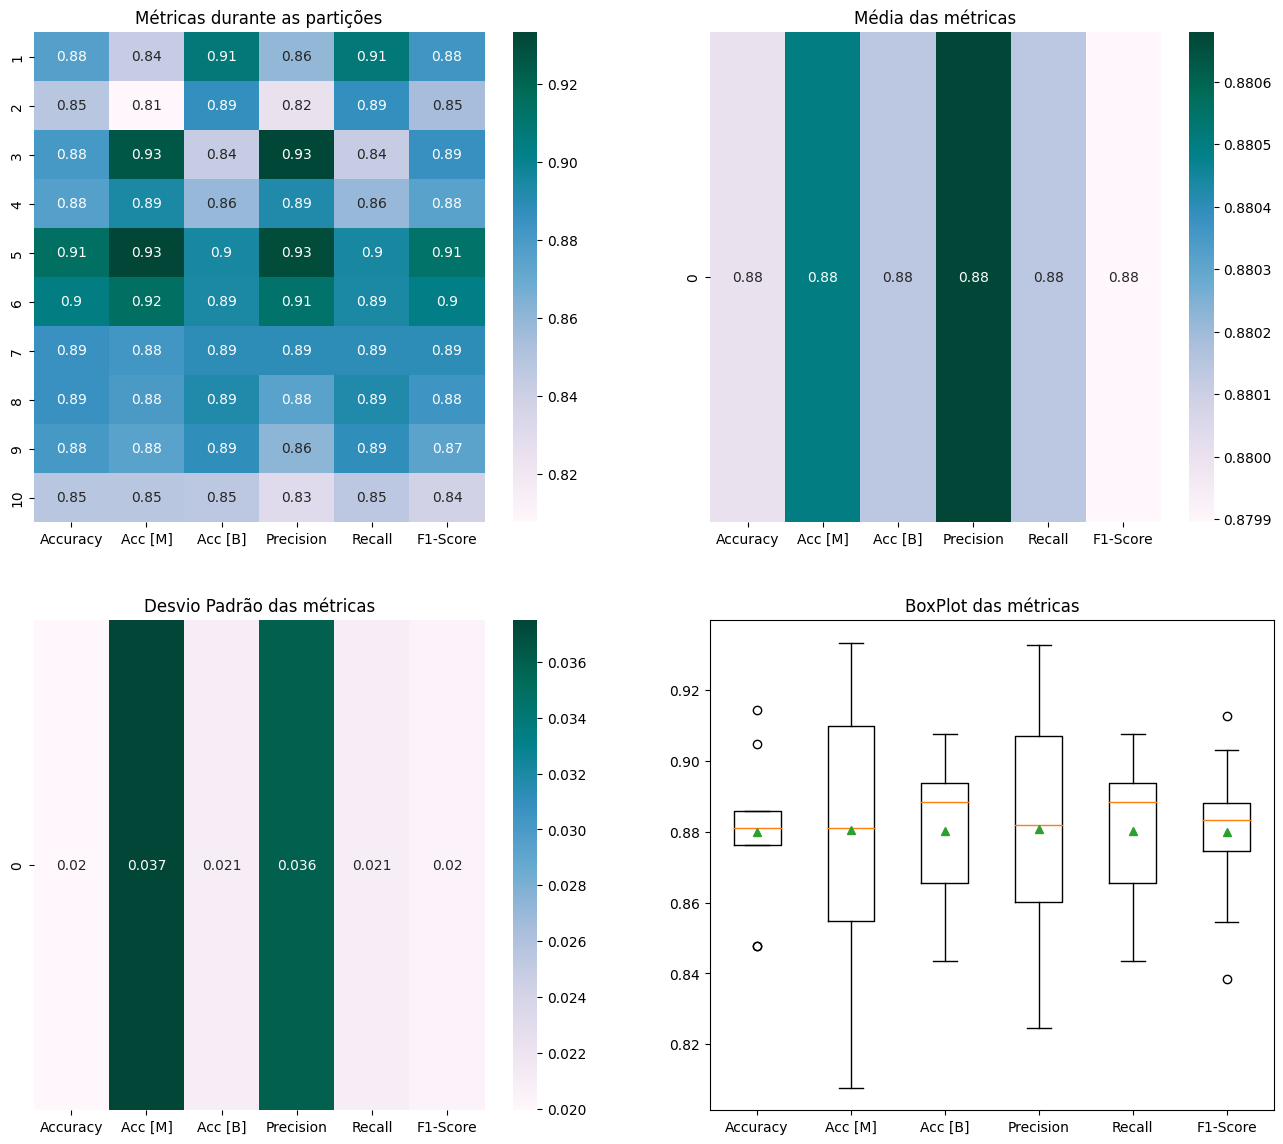

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(16, 14))

xlabels = ['Accuracy', 'Acc [M]', 'Acc [B]', 'Precision', 'Recall', 'F1-Score']

per_fold = sns.heatmap(metrics, annot=True, xticklabels=xlabels, yticklabels=range(1, 11), ax=ax[0][0], cmap='PuBuGn')
means = sns.heatmap(np.mean(metrics, axis=0).reshape(1, -1), annot=True, xticklabels=xlabels, ax=ax[0][1], cmap='PuBuGn')
std = sns.heatmap(np.std(metrics, axis=0).reshape(1, -1), annot=True, xticklabels=xlabels, ax=ax[1][0], cmap='PuBuGn')
ax[1][1].boxplot(metrics, labels=xlabels, showmeans=True)

ax[0][0].set_title('Métricas durante as partições')
ax[0][1].set_title('Média das métricas')
ax[1][0].set_title('Desvio Padrão das métricas')
ax[1][1].set_title('BoxPlot das métricas')

fig.savefig('./charts/metrics.svg')

### Plotting Confusion Matrix and Precision-Recall curve of both best and worst models

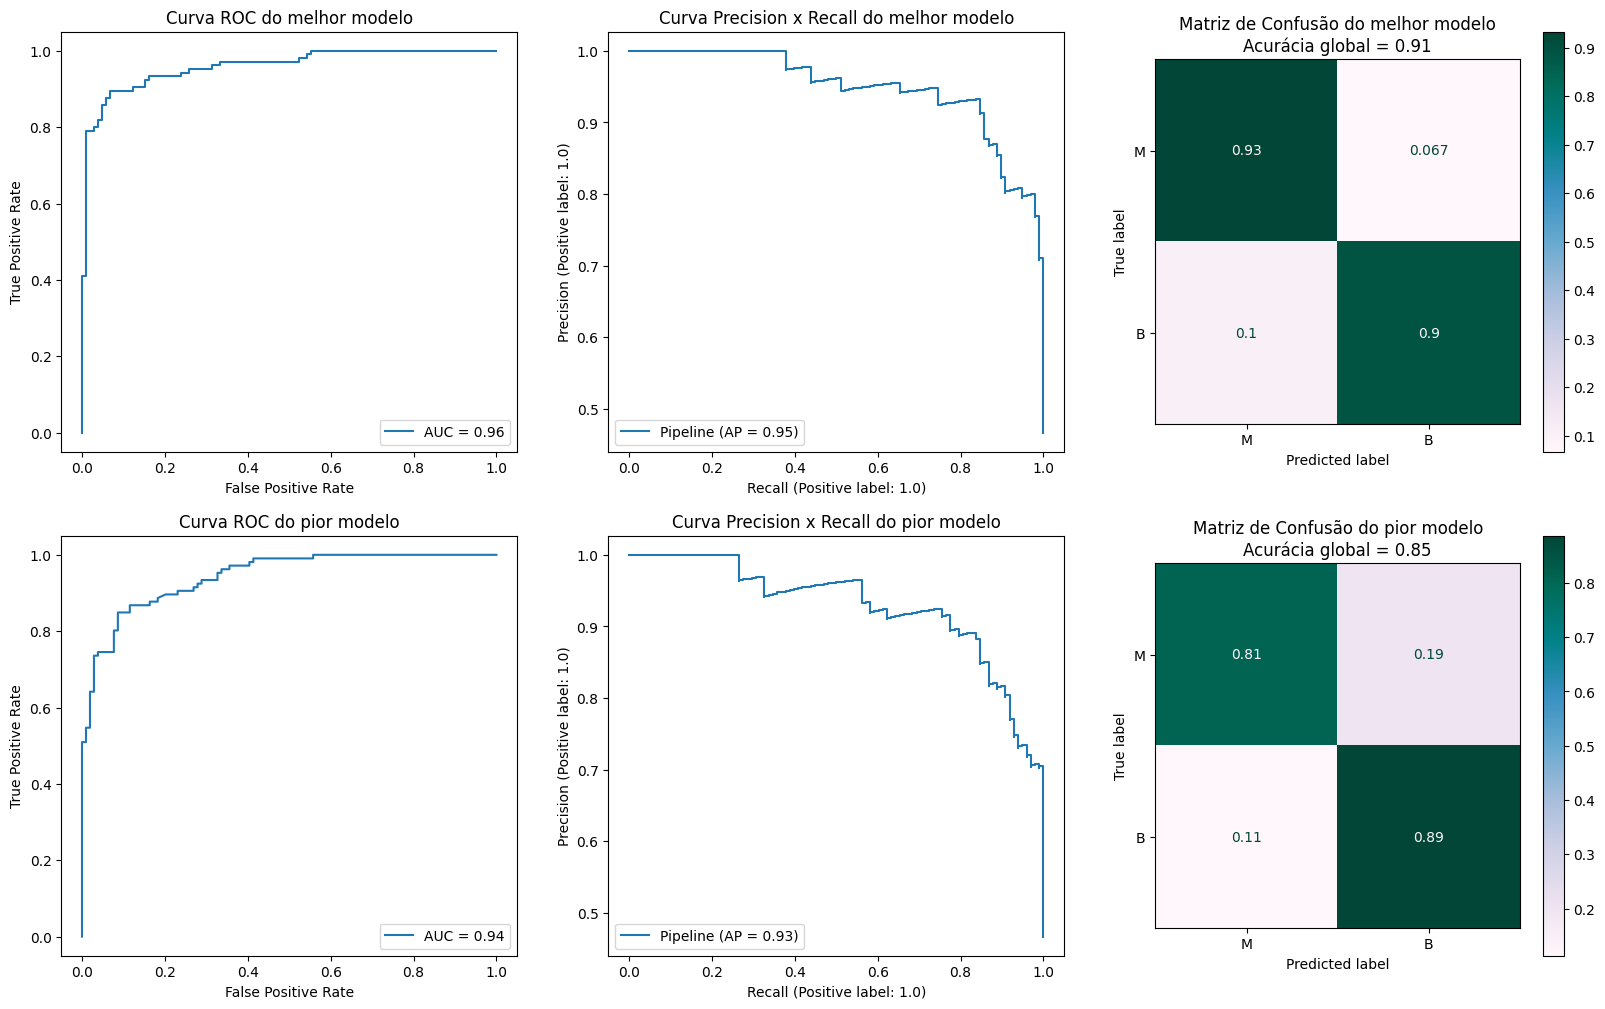

In [8]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay, auc

fig, ax = plt.subplots(2, 3, figsize=(20, 12))

best_roc_display = RocCurveDisplay(fpr=models[0][1][0], tpr=models[0][1][1], roc_auc=auc(models[0][1][0], models[0][1][1]))
best_pr_display = PrecisionRecallDisplay.from_estimator(models[0][2], test_attributes, test_targets, ax=ax[0][1])
best_cm_display = ConfusionMatrixDisplay(models[0][3], display_labels=['M', 'B'])

worst_roc_display = RocCurveDisplay(fpr=models[1][1][0], tpr=models[1][1][1], roc_auc=auc(models[1][1][0], models[1][1][1]))
worst_pr_display = PrecisionRecallDisplay.from_estimator(models[1][2], test_attributes, test_targets, ax=ax[1][1])
worst_cm_display = ConfusionMatrixDisplay(models[1][3], display_labels=['M', 'B'])

best_roc_display.plot(ax=ax[0][0])
best_cm_display.plot(ax=ax[0][2], cmap='PuBuGn')

worst_roc_display.plot(ax=ax[1][0])
worst_cm_display.plot(ax=ax[1][2], cmap='PuBuGn')

ax[0][0].set_title('Curva ROC do melhor modelo')
ax[0][1].set_title('Curva Precision x Recall do melhor modelo')
ax[0][2].set_title(f'Matriz de Confusão do melhor modelo\nAcurácia global = {models[0][0]:.2f}')
ax[1][0].set_title('Curva ROC do pior modelo')
ax[1][1].set_title('Curva Precision x Recall do pior modelo')
ax[1][2].set_title(f'Matriz de Confusão do pior modelo\nAcurácia global = {models[1][0]:.2f}')

fig.savefig('./charts/curves.svg')

## Training with full dataset, saving model

### Find best hyperparameters

In [9]:
final_model = Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC(probability=True, random_state=0))])

final_cv = GridSearchCV(estimator=final_model, param_grid=parameters, cv=5, n_jobs=-1)

final_cv.fit(attributes, targets.astype(float))

best_params = final_cv.best_params_

print(best_params)

{'svc__C': 10, 'svc__degree': 1, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}


### Training with full dataset and saving model

In [10]:
from joblib import dump

if best_params['svc__kernel'] == 'rbf':
    final_model = SVC(C=best_params['svc__C'], kernel=best_params['svc__kernel'], gamma=best_params['svc__gamma'])
else:
    final_model = SVC(C=best_params['svc__C'], kernel=best_params['svc__kernel'], degree=best_params['svc__degree'])

final_model.fit(attributes, targets.astype(float))

dump(final_model, './saved_models/poly_log_reg.joblib')

['./saved_models/poly_log_reg.joblib']